In [1]:
print(dict(type='Sigmoid'))

{'type': 'Sigmoid'}


In [3]:
import re
import json

def extract_json_from_prompts(prompts, reference, mask_strategy):
    ret_prompts = []
    for i, prompt in enumerate(prompts):
        parts = re.split(r"(?=[{])", prompt)
        assert len(parts) <= 2, f"Invalid prompt: {prompt}"
        ret_prompts.append(parts[0])
        if len(parts) > 1:
            additional_info = json.loads(parts[1])
            for key in additional_info:
                assert key in ["reference_path", "mask_strategy"], f"Invalid key: {key}"
                if key == "reference_path":
                    reference[i] = additional_info[key]
                elif key == "mask_strategy":
                    mask_strategy[i] = additional_info[key]
    return ret_prompts, reference, mask_strategy


# Example input
prompts = [
    "A beautiful sunset{\"reference_path\": \"sunset.jpg\", \"mask_strategy\": \"background\"}",
    "A mountain landscape",  # prompt without JSON
    "A city at night{\"reference_path\": \"city.jpg\"}"
]
reference = [None] * 3  # Initialize with None values
mask_strategy = [None] * 3  # Initialize with None values

# Let's call the function
ret_prompts, reference, mask_strategy = extract_json_from_prompts(prompts, reference, mask_strategy)


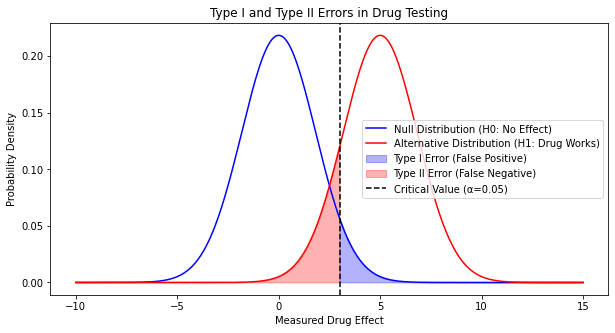

(0.050000000000000044, 0.13703030993578508)

In [4]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define parameters for a drug effectiveness test
true_mean_effect = 0  # The true effect of the drug (null hypothesis: no effect)
alternative_mean_effect = 5  # The actual effect if the drug works
std_dev = 10  # Standard deviation of the effect measurement
sample_size = 30  # Number of patients in each test group
alpha = 0.05  # Significance level (threshold for rejecting H0)

# Generate sampling distributions under null and alternative hypotheses
np.random.seed(42)
null_distribution = np.random.normal(true_mean_effect, std_dev / np.sqrt(sample_size), 10000)
alternative_distribution = np.random.normal(alternative_mean_effect, std_dev / np.sqrt(sample_size), 10000)

# Compute critical value for rejection region under H0
critical_value = stats.norm.ppf(1 - alpha, loc=true_mean_effect, scale=std_dev / np.sqrt(sample_size))

# Compute Type I error (false positive): Probability of rejecting H0 when it is true
type1_error_prob = 1 - stats.norm.cdf(critical_value, loc=true_mean_effect, scale=std_dev / np.sqrt(sample_size))

# Compute Type II error (false negative): Probability of failing to reject H0 when Ha is true
type2_error_prob = stats.norm.cdf(critical_value, loc=alternative_mean_effect, scale=std_dev / np.sqrt(sample_size))

# Plot distributions and critical region
plt.figure(figsize=(10, 5))
x_vals = np.linspace(-10, 15, 1000)
null_pdf = stats.norm.pdf(x_vals, true_mean_effect, std_dev / np.sqrt(sample_size))
alt_pdf = stats.norm.pdf(x_vals, alternative_mean_effect, std_dev / np.sqrt(sample_size))

plt.plot(x_vals, null_pdf, label="Null Distribution (H0: No Effect)", color="blue")
plt.plot(x_vals, alt_pdf, label="Alternative Distribution (H1: Drug Works)", color="red")

# Shade Type I error region (false positive)
plt.fill_between(x_vals, 0, null_pdf, where=(x_vals > critical_value), color='blue', alpha=0.3, label="Type I Error (False Positive)")

# Shade Type II error region (false negative)
plt.fill_between(x_vals, 0, alt_pdf, where=(x_vals < critical_value), color='red', alpha=0.3, label="Type II Error (False Negative)")

plt.axvline(critical_value, color='black', linestyle="--", label=f"Critical Value (α={alpha})")
plt.xlabel("Measured Drug Effect")
plt.ylabel("Probability Density")
plt.title("Type I and Type II Errors in Drug Testing")
plt.legend()
plt.show()

# Display error probabilities
type1_error_prob, type2_error_prob


In [8]:
examples = ["abc.", "def."]


result = "\n".join(examples)
print(result)

abc.
def.


In [ ]:
# Adapted from PixArt
#
# Copyright (C) 2023  PixArt-alpha/PixArt-alpha
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as published
# by the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.
#
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# PixArt: https://github.com/PixArt-alpha/PixArt-alpha
# T5:     https://github.com/google-research/text-to-text-transfer-transformer
# --------------------------------------------------------

import html
import re
from functools import partial

import ftfy
import torch
from transformers import AutoTokenizer, T5EncoderModel

from opensora.registry import MODELS


class T5Embedder:
    def __init__(
        self,
        device,
        from_pretrained=None,
        *,
        cache_dir=None,
        hf_token=None,
        use_text_preprocessing=True,
        t5_model_kwargs=None,
        torch_dtype=None,
        use_offload_folder=None,
        model_max_length=120,
        local_files_only=False,
    ):
        self.device = torch.device(device)
        self.torch_dtype = torch_dtype or torch.bfloat16
        self.cache_dir = cache_dir

        if t5_model_kwargs is None:
            t5_model_kwargs = {
                "low_cpu_mem_usage": True,
                "torch_dtype": self.torch_dtype,
            }

            if use_offload_folder is not None:
                t5_model_kwargs["offload_folder"] = use_offload_folder
                t5_model_kwargs["device_map"] = {
                    "shared": self.device,
                    "encoder.embed_tokens": self.device,
                    "encoder.block.0": self.device,
                    "encoder.block.1": self.device,
                    "encoder.block.2": self.device,
                    "encoder.block.3": self.device,
                    "encoder.block.4": self.device,
                    "encoder.block.5": self.device,
                    "encoder.block.6": self.device,
                    "encoder.block.7": self.device,
                    "encoder.block.8": self.device,
                    "encoder.block.9": self.device,
                    "encoder.block.10": self.device,
                    "encoder.block.11": self.device,
                    "encoder.block.12": "disk",
                    "encoder.block.13": "disk",
                    "encoder.block.14": "disk",
                    "encoder.block.15": "disk",
                    "encoder.block.16": "disk",
                    "encoder.block.17": "disk",
                    "encoder.block.18": "disk",
                    "encoder.block.19": "disk",
                    "encoder.block.20": "disk",
                    "encoder.block.21": "disk",
                    "encoder.block.22": "disk",
                    "encoder.block.23": "disk",
                    "encoder.final_layer_norm": "disk",
                    "encoder.dropout": "disk",
                }
            else:
                t5_model_kwargs["device_map"] = {
                    "shared": self.device,
                    "encoder": self.device,
                }

        self.use_text_preprocessing = use_text_preprocessing
        self.hf_token = hf_token

        self.tokenizer = AutoTokenizer.from_pretrained(
            from_pretrained,
            cache_dir=cache_dir,
            local_files_only=local_files_only,
        )
        self.model = T5EncoderModel.from_pretrained(
            from_pretrained,
            cache_dir=cache_dir,
            local_files_only=local_files_only,
            **t5_model_kwargs,
        ).eval()
        self.model_max_length = model_max_length
        self.tokenize_fn = partial(
            self.tokenizer,
            max_length=self.model_max_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt",
        )

    def get_text_embeddings(self, input_ids: torch.Tensor, attention_mask):
        input_ids = input_ids.to(self.device)
        if attention_mask is not None:
            attention_mask = attention_mask.to(self.device)
        with torch.no_grad():
            text_encoder_embs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )["last_hidden_state"].detach()
        return text_encoder_embs, attention_mask


@MODELS.register_module("t5")
class T5Encoder:
    def __init__(
        self,
        from_pretrained=None,
        model_max_length=120,
        device="cuda",
        dtype=torch.float,
        cache_dir=None,
        shardformer=False,
        local_files_only=False,
    ):
        assert from_pretrained is not None, "Please specify the path to the T5 model"

        self.t5 = T5Embedder(
            device=device,
            torch_dtype=dtype,
            from_pretrained=from_pretrained,
            cache_dir=cache_dir,
            model_max_length=model_max_length,
            local_files_only=local_files_only,
        )
        self.t5.model.to(dtype=dtype)
        self.y_embedder = None

        self.model_max_length = model_max_length
        self.output_dim = self.t5.model.config.d_model
        self.dtype = dtype

        if shardformer:
            self.shardformer_t5()

    # def shardformer_t5(self):
    #     # from colossalai.shardformer import ShardConfig, ShardFormer

    #     from opensora.acceleration.shardformer.policy.t5_encoder import T5EncoderPolicy
    #     from opensora.utils.misc import requires_grad

    #     shard_config = ShardConfig(
    #         tensor_parallel_process_group=None,
    #         pipeline_stage_manager=None,
    #         enable_tensor_parallelism=False,
    #         enable_fused_normalization=False,
    #         enable_flash_attention=False,
    #         enable_jit_fused=True,
    #         enable_sequence_parallelism=False,
    #         enable_sequence_overlap=False,
    #     )
    #     shard_former = ShardFormer(shard_config=shard_config)
    #     optim_model, _ = shard_former.optimize(self.t5.model, policy=T5EncoderPolicy())
    #     self.t5.model = optim_model.to(self.dtype)

    #     # ensure the weights are frozen
    #     requires_grad(self.t5.model, False)

    @property
    def tokenize_fn(self):
        return self.t5.tokenize_fn

    def encode(self, input_ids, attention_mask=None):
        caption_embs, emb_masks = self.t5.get_text_embeddings(input_ids, attention_mask)
        caption_embs = caption_embs[:, None]
        return dict(y=caption_embs, mask=emb_masks)

    def null(self, n):
        null_y = self.y_embedder.y_embedding[None].repeat(n, 1, 1)[:, None]
        return null_y


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


BAD_PUNCT_REGEX = re.compile(
    r"[" + "#®•©™&@·º½¾¿¡§~" + "\)" + "\(" + "\]" + "\[" + "\}" + "\{" + "\|" + "\\" + "\/" + "\*" + r"]{1,}"
)  # noqa


def clean_caption(caption):
    import urllib.parse as ul

    from bs4 import BeautifulSoup

    caption = str(caption)
    caption = ul.unquote_plus(caption)
    caption = caption.strip().lower()
    caption = re.sub("<person>", "person", caption)
    # urls:
    caption = re.sub(
        r"\b((?:https?:(?:\/{1,3}|[a-zA-Z0-9%])|[a-zA-Z0-9.\-]+[.](?:com|co|ru|net|org|edu|gov|it)[\w/-]*\b\/?(?!@)))",  # noqa
        "",
        caption,
    )  # regex for urls
    caption = re.sub(
        r"\b((?:www:(?:\/{1,3}|[a-zA-Z0-9%])|[a-zA-Z0-9.\-]+[.](?:com|co|ru|net|org|edu|gov|it)[\w/-]*\b\/?(?!@)))",  # noqa
        "",
        caption,
    )  # regex for urls
    # html:
    caption = BeautifulSoup(caption, features="html.parser").text

    # @<nickname>
    caption = re.sub(r"@[\w\d]+\b", "", caption)

    # 31C0—31EF CJK Strokes
    # 31F0—31FF Katakana Phonetic Extensions
    # 3200—32FF Enclosed CJK Letters and Months
    # 3300—33FF CJK Compatibility
    # 3400—4DBF CJK Unified Ideographs Extension A
    # 4DC0—4DFF Yijing Hexagram Symbols
    # 4E00—9FFF CJK Unified Ideographs
    caption = re.sub(r"[\u31c0-\u31ef]+", "", caption)
    caption = re.sub(r"[\u31f0-\u31ff]+", "", caption)
    caption = re.sub(r"[\u3200-\u32ff]+", "", caption)
    caption = re.sub(r"[\u3300-\u33ff]+", "", caption)
    caption = re.sub(r"[\u3400-\u4dbf]+", "", caption)
    caption = re.sub(r"[\u4dc0-\u4dff]+", "", caption)
    caption = re.sub(r"[\u4e00-\u9fff]+", "", caption)
    #######################################################

    # все виды тире / all types of dash --> "-"
    caption = re.sub(
        r"[\u002D\u058A\u05BE\u1400\u1806\u2010-\u2015\u2E17\u2E1A\u2E3A\u2E3B\u2E40\u301C\u3030\u30A0\uFE31\uFE32\uFE58\uFE63\uFF0D]+",  # noqa
        "-",
        caption,
    )

    # кавычки к одному стандарту
    caption = re.sub(r"[`´«»“”¨]", '"', caption)
    caption = re.sub(r"[‘’]", "'", caption)

    # &quot;
    caption = re.sub(r"&quot;?", "", caption)
    # &amp
    caption = re.sub(r"&amp", "", caption)

    # ip adresses:
    caption = re.sub(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", " ", caption)

    # article ids:
    caption = re.sub(r"\d:\d\d\s+$", "", caption)

    # \n
    caption = re.sub(r"\\n", " ", caption)

    # "#123"
    caption = re.sub(r"#\d{1,3}\b", "", caption)
    # "#12345.."
    caption = re.sub(r"#\d{5,}\b", "", caption)
    # "123456.."
    caption = re.sub(r"\b\d{6,}\b", "", caption)
    # filenames:
    caption = re.sub(r"[\S]+\.(?:png|jpg|jpeg|bmp|webp|eps|pdf|apk|mp4)", "", caption)

    #
    caption = re.sub(r"[\"\']{2,}", r'"', caption)  # """AUSVERKAUFT"""
    caption = re.sub(r"[\.]{2,}", r" ", caption)  # """AUSVERKAUFT"""

    caption = re.sub(BAD_PUNCT_REGEX, r" ", caption)  # ***AUSVERKAUFT***, #AUSVERKAUFT
    caption = re.sub(r"\s+\.\s+", r" ", caption)  # " . "

    # this-is-my-cute-cat / this_is_my_cute_cat
    regex2 = re.compile(r"(?:\-|\_)")
    if len(re.findall(regex2, caption)) > 3:
        caption = re.sub(regex2, " ", caption)

    caption = basic_clean(caption)

    caption = re.sub(r"\b[a-zA-Z]{1,3}\d{3,15}\b", "", caption)  # jc6640
    caption = re.sub(r"\b[a-zA-Z]+\d+[a-zA-Z]+\b", "", caption)  # jc6640vc
    caption = re.sub(r"\b\d+[a-zA-Z]+\d+\b", "", caption)  # 6640vc231

    caption = re.sub(r"(worldwide\s+)?(free\s+)?shipping", "", caption)
    caption = re.sub(r"(free\s)?download(\sfree)?", "", caption)
    caption = re.sub(r"\bclick\b\s(?:for|on)\s\w+", "", caption)
    caption = re.sub(r"\b(?:png|jpg|jpeg|bmp|webp|eps|pdf|apk|mp4)(\simage[s]?)?", "", caption)
    caption = re.sub(r"\bpage\s+\d+\b", "", caption)

    caption = re.sub(r"\b\d*[a-zA-Z]+\d+[a-zA-Z]+\d+[a-zA-Z\d]*\b", r" ", caption)  # j2d1a2a...

    caption = re.sub(r"\b\d+\.?\d*[xх×]\d+\.?\d*\b", "", caption)

    caption = re.sub(r"\b\s+\:\s+", r": ", caption)
    caption = re.sub(r"(\D[,\./])\b", r"\1 ", caption)
    caption = re.sub(r"\s+", " ", caption)

    caption.strip()

    caption = re.sub(r"^[\"\']([\w\W]+)[\"\']$", r"\1", caption)
    caption = re.sub(r"^[\'\_,\-\:;]", r"", caption)
    caption = re.sub(r"[\'\_,\-\:\-\+]$", r"", caption)
    caption = re.sub(r"^\.\S+$", "", caption)

    return caption.strip()


def text_preprocessing(text, use_text_preprocessing: bool = True):
    if use_text_preprocessing:
        # The exact text cleaning as was in the training stage:
        text = clean_caption(text)
        text = clean_caption(text)
        return text
    else:
        return text.lower().strip()


In [1]:
text_encoder=T5Encoder()

# Example usage:
prompts = ["a cat playing with yarn", "a dog running in a park"]
tokenized = text_encoder.tokenize_fn(prompts)
# might return something like: {'input_ids': [...], 'attention_mask': [...]}
model_args = text_encoder.encode(**tokenized)
# model_args now contains the numerical representations needed for the model

NameError: name 'T5Encoder' is not defined